# Определение возраста покупателей

Необходимо построить модель для определения возраста покупателя по фотографии его лица.

Модель определения возраста предполагается заказчиком использовать в целях:
- Анализа покупки и дальнейшего предложения товаров, которые могут заинтересовать покупателей этой возрастной группы;
- Контроля добросовестности кассиров при продаже алкоголя.

## Исследовательский анализ данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [ ]:
df = pd.read_csv('/datasets/faces/labels.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
df['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

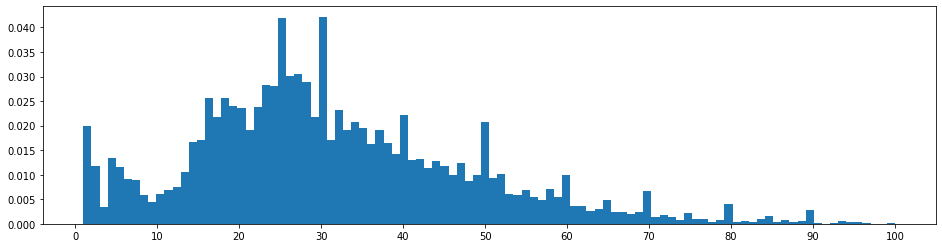

In [ ]:
plt.figure(figsize=(16, 4))
plt.xticks(range(0, 110, 10))

_ = plt.hist(df['real_age'], density=True, bins=100)

По приведенным данным можно сделать вывод, что данные корректны. Очевидных выбросов нет. Возраст покупателей варьируется в разумных пределах. Возможно стоит ограничить выборку минимальным возрастом покупателя, например в районе 2 или 3 лет.

Found 7591 validated image filenames.


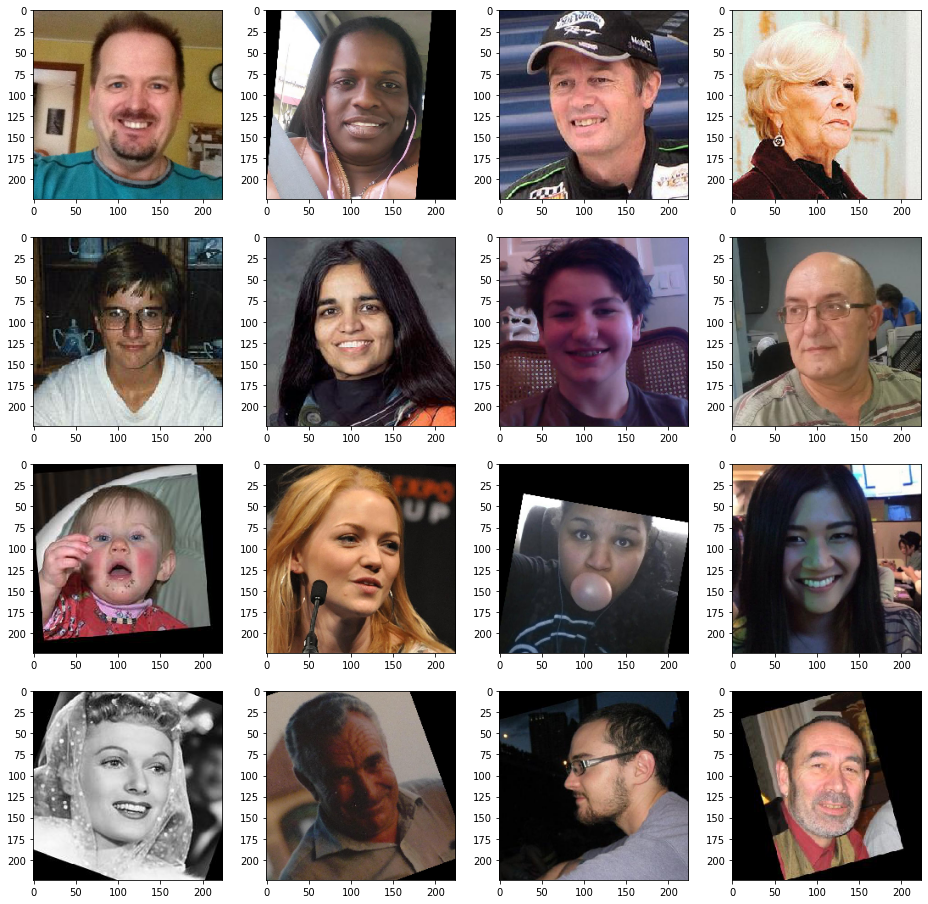

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
train = datagen.flow_from_dataframe(df, '/datasets/faces/final_files/', 
                                    x_col='file_name', y_col='real_age', 
                                    target_size=(224, 224), batch_size=32, 
                                    class_mode='raw', seed=12345)

features, target = next(train)

fig = plt.figure(figsize=(16, 16))
for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(features[i])

<li/>Датасет содержит более 7500 фотографий. Если бы распределение было равномерным, то на каждый интервал в один год приходилось бы более 75 фотографий. Что, пожалуй, можно было бы считать достаточным количеством. Однако в предоставленном датасете возраст распределен неравномерно. 

<li/>Половина фотографий относится к интервалу от 20 до 41 года. Заметная часть набора содержит фотографии детей до 10 лет. Всплески числа представителей "юбилейных" лет могут говорить об "округлении" возрастов по части данных. В то же время, можно предположить, что для сбора датасета использовались фотографии с гарантированно известным возрастом. Что, в частности, может быть обеспечено использованием фотографий с празднований юбилеев. В любом случае стоит заострить внимание заказчика на обнаруженной особенности.
    
<li/>Наличие черно-белых фотографий, по-видимому, несет негативное влияние. Т.к. в работе предполагается цветные изображения, то обученная модель никогда не увидит черно-белых снимков. Тот же факт, что часть фотографий явно вырезаны из каких-то других, больших по размеру, фотографий говорит, собственно, о том, что использованы фотографии из каких-то открытых источников. Важнее, что соответствующий им возраст был указан корректно. 
    
<li/>Для обеспечения большего разнообразия обучающей выборки можно рекомендовать использовать следующий аугментациии: отражение относительно вертикальной оси, сдвиги, повороты в пределах 15-30 градусов.
    
<li/>Наверное в действительности я бы предложил рассмотреть разделение задачи заказчика на две обособленные, и для решения каждой из них подготовить две модели. Первая задача звучала бы как "Подбор потенциально интересующих конкретного покупателя дополнительных товаров в зависимости от его возрастной группы". Вторая - "Определение является ли возраст покупателя допустимым для продажи ему алкогольной продукции". В обеих подзадачах важен не конкретный возраст, а отнесение к одному из классов. Выделение классов возрастных групп для рекомендательной системы потребует, скорее всего, отдельного анализа. Вторая подзадача сведется к бинарной классификации. 

## Обучение модели

```python

import numpy as np
import pandas as pd

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255,
                                width_shift_range=.15, 
                                height_shift_range=.15)
    
    train_datagen_flow = datagen.flow_from_dataframe(
                labels,
                path + '/final_files', 
                x_col='file_name', y_col='real_age', 
                target_size=(224, 224), 
                batch_size=16,
                class_mode='raw', 
                subset='training',
                seed=12345)

    return train_datagen_flow
    
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    test_datagen_flow = datagen.flow_from_dataframe(
                labels,
                path + '/final_files', 
                x_col='file_name', y_col='real_age', 
                target_size=(224, 224), 
                batch_size=16,
                class_mode='raw', 
                subset='validation',
                seed=12345)

    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    optimizer=Adam(0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=4,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 1s
   65536/94765736 [..............................] - ETA: 1:12
  196608/94765736 [..............................] - ETA: 49s 
  491520/94765736 [..............................] - ETA: 29s
 1253376/94765736 [..............................] - ETA: 15s
 3055616/94765736 [..............................] - ETA: 7s 
 6922240/94765736 [=>............................] - ETA: 3s
10854400/94765736 [==>...........................] - ETA: 2s
15089664/94765736 [===>..........................] - ETA: 2s
19177472/94765736 [=====>........................] - ETA: 1s
22781952/94765736 [======>.......................] - ETA: 1s
26763264/94765736 [=======>......................] - ETA: 1s
30810112/94765736 [========>.....................] - ETA: 1s
34922496/94765736 [==========>...................] - ETA: 1s
38805504/94765736 [===========>..................] - ETA: 1s
42557440/94765736 [============>.................] - ETA: 0s
46407680/94765736 [=============>................] - ETA: 0s
50544640/94765736 [===============>..............] - ETA: 0s
54665216/94765736 [================>.............] - ETA: 0s
58662912/94765736 [=================>............] - ETA: 0s
62349312/94765736 [==================>...........] - ETA: 0s
66134016/94765736 [===================>..........] - ETA: 0s
70180864/94765736 [=====================>........] - ETA: 0s
73768960/94765736 [======================>.......] - ETA: 0s
77455360/94765736 [=======================>......] - ETA: 0s
81731584/94765736 [========================>.....] - ETA: 0s
85991424/94765736 [==========================>...] - ETA: 0s
89759744/94765736 [===========================>..] - ETA: 0s
94003200/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/4
2022-09-04 20:03:34.504910: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-04 20:03:35.644447: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 129s - loss: 222.2436 - mae: 10.8062 - val_loss: 659.3755 - val_mae: 20.5000
Epoch 2/4
356/356 - 96s - loss: 88.2673 - mae: 7.1117 - val_loss: 181.3638 - val_mae: 9.9408
Epoch 3/4
356/356 - 95s - loss: 67.4923 - mae: 6.3082 - val_loss: 96.7392 - val_mae: 7.2468
Epoch 4/4
356/356 - 95s - loss: 49.6105 - mae: 5.4377 - val_loss: 82.6210 - val_mae: 6.7000
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 82.6210 - mae: 6.7000
Test MAE: 6.7000
```

## Анализ обученной модели

Указанного результата удалось добиться на моделе ResNet50 предобученного на датасете 'imagenet', с применением оптимизатора Adam при значении lr = 0.0001. Кроме того была выполнена аугментация исходного датасета. А именно сдвиг по высоте и ширине в пределах 15% размера изображений.